# Sequential Graph
We want to now learn how to create and handle multiple nodes in a graph\
NOTE: THIS WAS COVERED IN THE LAST PARTS OF GRAPH-1 and GRAPH-2, so skipping over this. 

# Conditional Graph
### Our goal here is to learn how to switch between nodes conditionally and use the `add_conditional_edges()` method
Objectives:
- Implement conditional logic to route the flow of data to different nodes
- Using START and END nodes to manage the entry and exit points properly
- design multiple nodes to perform different operations
- create a `router node` to handle decision making and control the flow

```mermaid
    flowchart LR
    START --> A[input taker and decision maker]
    A[input taker and decision maker] --addition_edge--> B[Adder]
    A[input taker and decision maker] --subtraction_edge--> C[Subtractor]
    A[input taker and decision maker] --division_edge--> D[dividor]
    A[input taker and decision maker] --multiplication_edge--> E[multiplier]
    B[Adder] --> END
    C[Subtractor] --> END
    D[dividor] --> END
    E[multiplier] --> END
```

In [157]:
from typing import TypedDict, List
# we import START and END to get explicitly defined start and end point nodes
from langgraph.graph import StateGraph, START, END

In [158]:
class AgentState(TypedDict):
    operation: str
    number1: int
    number2: int
    finalnumber: float

In [159]:
def adder(state:AgentState) -> AgentState:
    """adds the two numbers in the state schema"""
    state['finalnumber'] = state['number1'] + state['number2']
    return state

def subtractor(state:AgentState) -> AgentState:
    """subtracts the two numbers in the state schema"""
    state['finalnumber'] = state['number1'] - state['number2']
    return state

def multiplier(state:AgentState) -> AgentState:
    """multiplies the two numbers in the state schema"""
    state['finalnumber'] = state['number1'] * state['number2']
    return state

def dividor(state:AgentState) -> AgentState:
    """divides the two numbers in the state schema"""
    state['finalnumber'] = state['number1'] / state['number2']
    return state

Now, to implement the decision maker (router) node's logic, it is important to understand what it does. Basically a bunch of if statements inside the node, but **the edge is returned instead of calling the next function, ie, you will name the addition edge and return that edge instead of the addition node.**\
Essentially you return the edge connecting the router node to the next node instead of returning the next node itself

In [160]:
def decision_maker(state:AgentState) -> AgentState:
    """decides the next node of the graph"""
    # notice that in this function, no changes to the state are being made, so we can use lambda as the passthrough function when we use graph.add_node
    
    if state['operation'] == "+":
        return "addition_edge"
    elif state['operation'] == "-":
        return "subtraction_edge"
    elif state['operation'] == "*":
        return "multiplication_edge"
    elif state['operation'] == "/":
        return "division_edge"

In [161]:
graph = StateGraph(AgentState)

graph.add_node("adder", adder)
graph.add_node("subtractor", subtractor)
graph.add_node("multiplier", multiplier)
graph.add_node("dividor", dividor)

graph.add_node("router", lambda state: state) # passthrough function

graph.add_edge(START, "router") # start --> router

graph.add_conditional_edges( # router --> others
    "router", # source
    decision_maker, # path
    { # path map
     "addition_edge": "adder",
     "subtraction_edge": "subtractor",
     "multiplication_edge": "multiplier",
     "division_edge": "dividor" 
    }
)

# others --> end
graph.add_edge("adder", END)
graph.add_edge("subtractor", END)
graph.add_edge("multiplier", END)
graph.add_edge("dividor", END)

app = graph.compile()

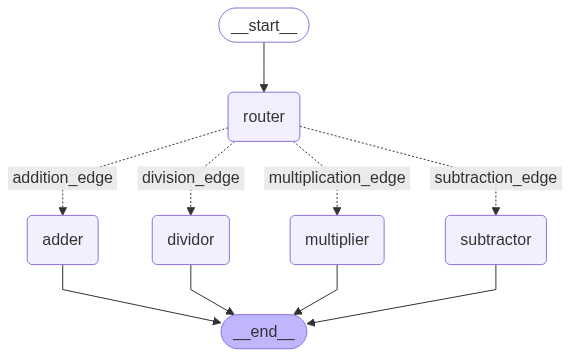

In [162]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [163]:
add_Result = app.invoke({'operation':"+", 'number1':2, 'number2':5})
print(add_Result)
print(add_Result['finalnumber'])

subtract_Result = app.invoke({'operation':"-", 'number1':2, 'number2':5})
print(subtract_Result)
print(subtract_Result['finalnumber'])

{'operation': '+', 'number1': 2, 'number2': 5, 'finalnumber': 7}
7
{'operation': '-', 'number1': 2, 'number2': 5, 'finalnumber': -3}
-3


## Task:
Make a graph like this: (first perform some operation on two numbers, then return if the answer is more than the average of the two numbers or not)
```mermaid
    flowchart LR
    START --> A[router]
    A[router 1] --addition_edge--> B[adder node]
    A[router 1] --subtraction_edge--> C[subtractor node]
    B[adder node] --> D[router 2]
    C[subtractor node] --> D[router 2]
    D[router 2] --checker for more than avg--> E[YES]
    D[router 2] --checker for less than avg--> F[NO]
    E[YES] --> END
    F[NO] --> END
```

In [170]:
class AgentState(TypedDict):
    operator: str
    num1: int
    num2: int
    average: float
    result: int
    decision: str

In [171]:
def adder(state:AgentState) -> AgentState:
    """adds num1 and num2"""
    state['result'] = state['num1'] + state['num2']
    return state

def subtractor(state:AgentState) -> AgentState:
    """subtracts num1 and num2"""
    state['result'] = state['num1'] - state['num2']
    return state
    
def router_1(state:AgentState) -> AgentState:
    """decides to add or subtract them"""
    if state['operator'] == "+":
        return "addition_edge"
    elif state['operator'] == "-":
        return "subtraction_edge"
    
def yesprinter(state:AgentState) -> AgentState:
    """prints yes if the decision is yes"""
    print("Looks like the result is greater than the average, which is: " + str(state['average']))
    state['decision'] = "YES"
    return state

def noprinter(state:AgentState) -> AgentState:
    """prints no if the decision is no"""
    print("Looks like the result is less than the average, which is: " + str(state['average']))
    state['decision'] = "NO"
    return state

def avg_calc(state:AgentState) -> AgentState:
    state['average'] = (state['num1'] + state['num2'])/2
    return state


def router_2(state:AgentState) -> AgentState:
    """calculates the average and compares it with result"""
    if state['average'] < state['result']:
        return "checker for more than avg"
    elif state['average'] >= state['result']:
        return "checker for less than avg"
    

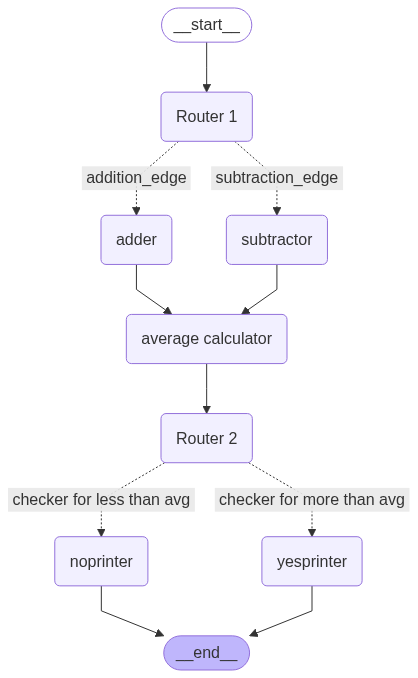

In [172]:
graph = StateGraph(AgentState)

graph.add_node("adder", adder)
graph.add_node("subtractor", subtractor)
graph.add_node("average calculator", avg_calc)
graph.add_node("yesprinter", yesprinter)
graph.add_node("noprinter", noprinter)

graph.add_node("Router 1", lambda state: state) #passthrough function
graph.add_node("Router 2", lambda state: state)

"""another way we could do this is:
def passthrough(state: AgentState) -> AgentState:
    return state
    
graph.add_node("Router 1", passthrough)

so basically a lambda function just makes it easy
"""

graph.add_edge(START, "Router 1") # start --> router 1
graph.add_conditional_edges( # router 1 --> add/sub
    "Router 1",
    router_1,
    {
        "addition_edge": "adder",
        "subtraction_edge": "subtractor"
    }
)
# add/sub --> router 2
graph.add_edge("adder","average calculator")
graph.add_edge("subtractor", "average calculator")
graph.add_edge("average calculator", "Router 2")


graph.add_conditional_edges( # router 2 --> yes/no
    "Router 2",
    router_2,
    {
        "checker for more than avg": "yesprinter",
        "checker for less than avg": "noprinter"
    }
)

# yes/no --> end
graph.add_edge("yesprinter",END)
graph.add_edge("noprinter", END)

app = graph.compile()
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [175]:
res1 = app.invoke({'operator':"+", 'num1':10, 'num2':5})
print(res1['decision'])
print()
print(res1)

Looks like the result is greater than the average, which is: 7.5
YES

{'operator': '+', 'num1': 10, 'num2': 5, 'average': 7.5, 'result': 15, 'decision': 'YES'}
